In [ ]:
from Bio import SeqIO, AlignIO, Phylo
from Bio.SeqRecord import SeqRecord
import Bio.Align
from Bio.Align.AlignInfo import SummaryInfo
from Bio.Seq import Seq
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import scipy as sp


In [ ]:
#complete these variables with the input files directory 
platform = input("where are you working (computer/laptop)?" )

#computer dir
if platform == "computer":
    dog_breeds = r"C:\Users\lena1\OneDrive - Birkbeck, University of London\UNI\Biocomputing\Coursework\data\dog_breeds.fa"
    mystery_breed = r"C:\Users\lena1\OneDrive - Birkbeck, University of London\UNI\Biocomputing\Coursework\data\mystery.fa"
    output = r"C:\Users\lena1\OneDrive - Birkbeck, University of London\UNI\Biocomputing\Coursework\results"
    ind_breeds = r"C:\Users\lena1\OneDrive - Birkbeck, University of London\UNI\Biocomputing\Coursework\individual_breed_sequences"

#laptop dir 
if platform == "laptop":
    dog_breeds = r"C:\Users\User\OneDrive - Birkbeck, University of London\UNI\Biocomputing\Coursework\data\dog_breeds.fa"
    mystery_breed = r"C:\Users\User\OneDrive - Birkbeck, University of London\UNI\Biocomputing\Coursework\data\mystery.fa"
    output = r"C:\Users\User\OneDrive - Birkbeck, University of London\UNI\Biocomputing\Coursework\results"
    ind_breeds = r"C:\Users\User\OneDrive - Birkbeck, University of London\UNI\Biocomputing\Coursework\individual_breed_sequences"

In [ ]:
class Breed():
    """class to store information about every breed and their sequence"""
    all_instances = []
    def __init__(self, sequence, breed, fasta):
        self.sequence = sequence
        self.breed = breed
        self.fasta = fasta
        Breed.all_instances.append(self)  #stores all initialised sequences


In [175]:
#open the fasta file and save the sequence breed and sequence name in a Breed Class to ba sccessed at a later point 
all_breeds = set()
for record in SeqIO.parse(dog_breeds, "fasta"):
    for key in list(record.description.split("[")):  #get the description of each sequence 
        if "breed" in key and "isolate" not in key: #get breed name 
            record.name = Breed(record.seq, key[6:-2], record)
            #get a list of all the Breeds in the database
            all_breeds.add(key[6:-2])

SyntaxError: cannot assign to function call here. Maybe you meant '==' instead of '='? (2255668615.py, line 6)

In [ ]:

#write a fasta file containing all sequences that belong to the same breed 
os.chdir(ind_breeds) # set up directory where files will be created
for breed in all_breeds: # creates a temporary variable corresponding to each individual dog breed 
    temp = breed
    file = open(breed, "w") #creates a filename eith the name of the breed in a writable format
    for key in Breed.all_instances: 
        if key.breed == temp: #itterates through all of the class instances and checks if the breedd is the same as the breed in all_breeds
            SeqIO.write(key.fasta, file, "fasta") #adds the sequence to the file 
    file.close() #once all the sequences are added file is closed


In [ ]:
#create a consensus sequence for each breed 
consensus_sequences = [] #store the concensus sequences in a fasta format 
os.chdir(ind_breeds) #set directory to where the sequences are 
for file in all_breeds:
    alignments = AlignIO.parse(file, "fasta") #align all the sequences in each file
    recordname = f"{file}" #create a record name  
    #create a consensus file for all alignements
    for alignment in alignments: 
        summary = SummaryInfo(alignment) #get summary info of each alignment to create a concensus 
        consensus = summary.dumb_consensus() #create a concensus of each alignmernt 
        # Create a SeqRecord with an ID (you can customize this)
        seq_record = SeqRecord(Seq(consensus), id=recordname) #create a fasta format sequence using the consensus sequence and recordname
        consensus_sequences.append(seq_record)#add each concensus seq to a list 

In [ ]:
#add mystery sequence to the concensus file list 
unknown_sequence = SeqIO.read(mystery_breed, "fasta") #get sequence from file 
consensus_sequences.append(SeqRecord(unknown_sequence.seq, id="mystery_sequence"))

#store concensus sequences in a results file 
concensus_filename = f"{output}/concensus_sequences"  
with open(concensus_filename, "w"):
        SeqIO.write(consensus_sequences, concensus_filename, "fasta") #adds the sequence to the file 


In [ ]:
def alignment(n, mystery_sequence = mystery_breed, breed_seqs =consensus_sequences):
    """Takes in index number of the alignment score (0 being the top scoring sequence), an unknown sequence (predifined) and compares it to the database(predifined) to return the top alignment
    n is the required paramater, mystery_sequence and breed_seeqs can be substituted with a different dataset"""
    all_scores = []
    for record in SeqIO.parse(mystery_sequence, "fasta"): #get sequence from file 
        unknown_sequence = record.seq
    # Create a pairwise alignment
    aligner = Bio.Align.PairwiseAligner() 
    for record in breed_seqs: 
        score = aligner.score(record.seq, unknown_sequence) #get the alinment score of each comparasion 
        all_scores.append(score)
    all_scores.sort(reverse=True) # sort the alignment scores from highest to lowest  
    #get the n'th alignment score 
    target_score = all_scores[n]
    for record in breed_seqs:
        if aligner.score(record.seq, unknown_sequence) == target_score:
            alignment = aligner.align(record.seq, unknown_sequence)
            breed_score = (record.id).replace("_consensus", ""), record.seq, alignment[0], target_score #find out what breed and sequence is asociated withe the maximum score 
    return breed_score

In [ ]:
def percentage_similarity(aln):
    """Given an alignment as aln calculates the percentage similarity between the two sequences"""
    identical_columns = float()
    #itterate through every column of the alignment
    for a in range(len(aln[0])): 
        #check if first and second sequence at column a is the same 
        if aln[0,a] == aln[1,a]: 
            #if base at position a is the same in bothe sequences add 1 to the amount of identical columns 
            identical_columns += 1
    #calculate the percentage 
    percentage = 100 * identical_columns / float(len(aln[0])) 
    #return percentage to 3dp
    return  round(percentage,3) 

In [ ]:
#calculate percentage similarity of the top scoring sequence and set variable to hold the top alignment and its details 
top_percentage = percentage_similarity((alignment(0)[2]))
full_top_alignment = alignment(0)
top_alignment = full_top_alignment[2]

In [ ]:
#create a file to store the top scoring alignment
filename = f"{output}/top_alignment_output"  
with open(filename, "w"):
        Bio.Align.write(top_alignment, filename, "clustal")


In [ ]:
#get results aka the breed, its sequence and percentage similarity 
results = "The breed most similar to the mustery DNA file is the", full_top_alignment[0], "its percent identity is", top_percentage, "% and the breeds consensus sequence is:", full_top_alignment[1],"the alignment of the mystery dog breed and", full_top_alignment[0], "is displayed here\n", full_top_alignment[2]

#create a string representing thr results that can be written to the results file 
results_str = str()
for key in results:
    results_str += str(key) 

In [ ]:
#create a file to store details about the  top alignment 
filename2 = f"{output}/top_alignment_details"  
with open(filename2, "w") as file:
        file.write(results_str)

In [ ]:
#create a multisequence alignment between unknownn dna and all concensus sequences
# Create a MultipleSeqAlignment object
alignment = Bio.Align.MultipleSeqAlignment(consensus_sequences)
#save the multiple sequence alignment in a file 
filename = f"{output}/MSA_alignment"  
AlignIO.write(alignment, filename, "clustal")


1

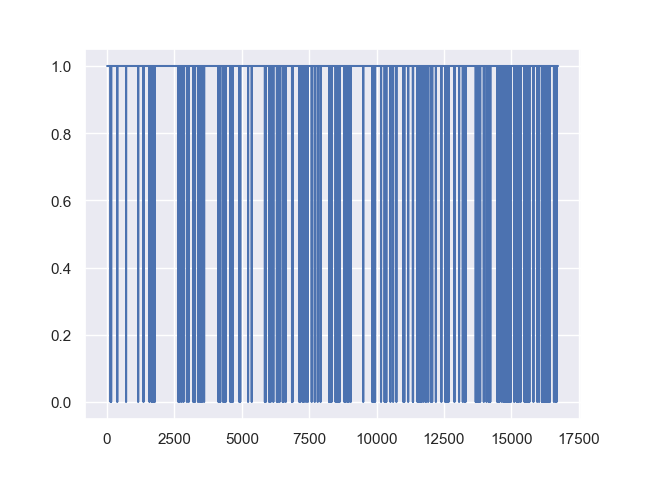

In [186]:
#to be improved
conservation = []
for n in range(len(alignment[0])):
    if len(set(alignment[:, n])) == 1:
        conservation.append(1)
    else:
        conservation.append(0)

x = np.arange(len(conservation))

plt.plot(x, conservation)

In [ ]:
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import Phylo

# Calculate the distance matrix
calculator = DistanceCalculator("identity")
distance_matrix = calculator.get_distance(alignment)

# Build the tree using the neighbor-joining method
constructor = DistanceTreeConstructor(calculator, method="nj")
breeds_tree = constructor.build_tree(alignment)
# Save the tree to a new file 

Phylo.write(breeds_tree, "breeds_tree.xml", "phyloxml")
# Convert the tree to a different format (optional)
Phylo.convert("breeds_tree.xml", "phyloxml", "breeds_tree.nex", "nexus")

Tree(rooted=False)
    Clade(branch_length=0, name='Inner38')
        Clade(branch_length=1.1430187014488142e-05, name='Inner37')
            Clade(branch_length=4.8193519849859046e-05, name='Inner36')
                Clade(branch_length=2.5257771262845302e-05, name='Inner35')
                    Clade(branch_length=0.00022386243744399213, name='Portuguese Water dog')
                    Clade(branch_length=8.885930964293932e-05, name='Inner34')
                        Clade(branch_length=7.533565506422736e-05, name='Inner33')
                            Clade(branch_length=0.0003213582125784144, name='Staffordshire Bull Terrier')
                            Clade(branch_length=3.717181431130796e-05, name='Inner32')
                                Clade(branch_length=0.00022618202868240854, name='Pit bull')
                                Clade(branch_length=1.2837989244119291e-05, name='Inner31')
                                    Clade(branch_length=7.469375560217981e-06, name='Cani

1

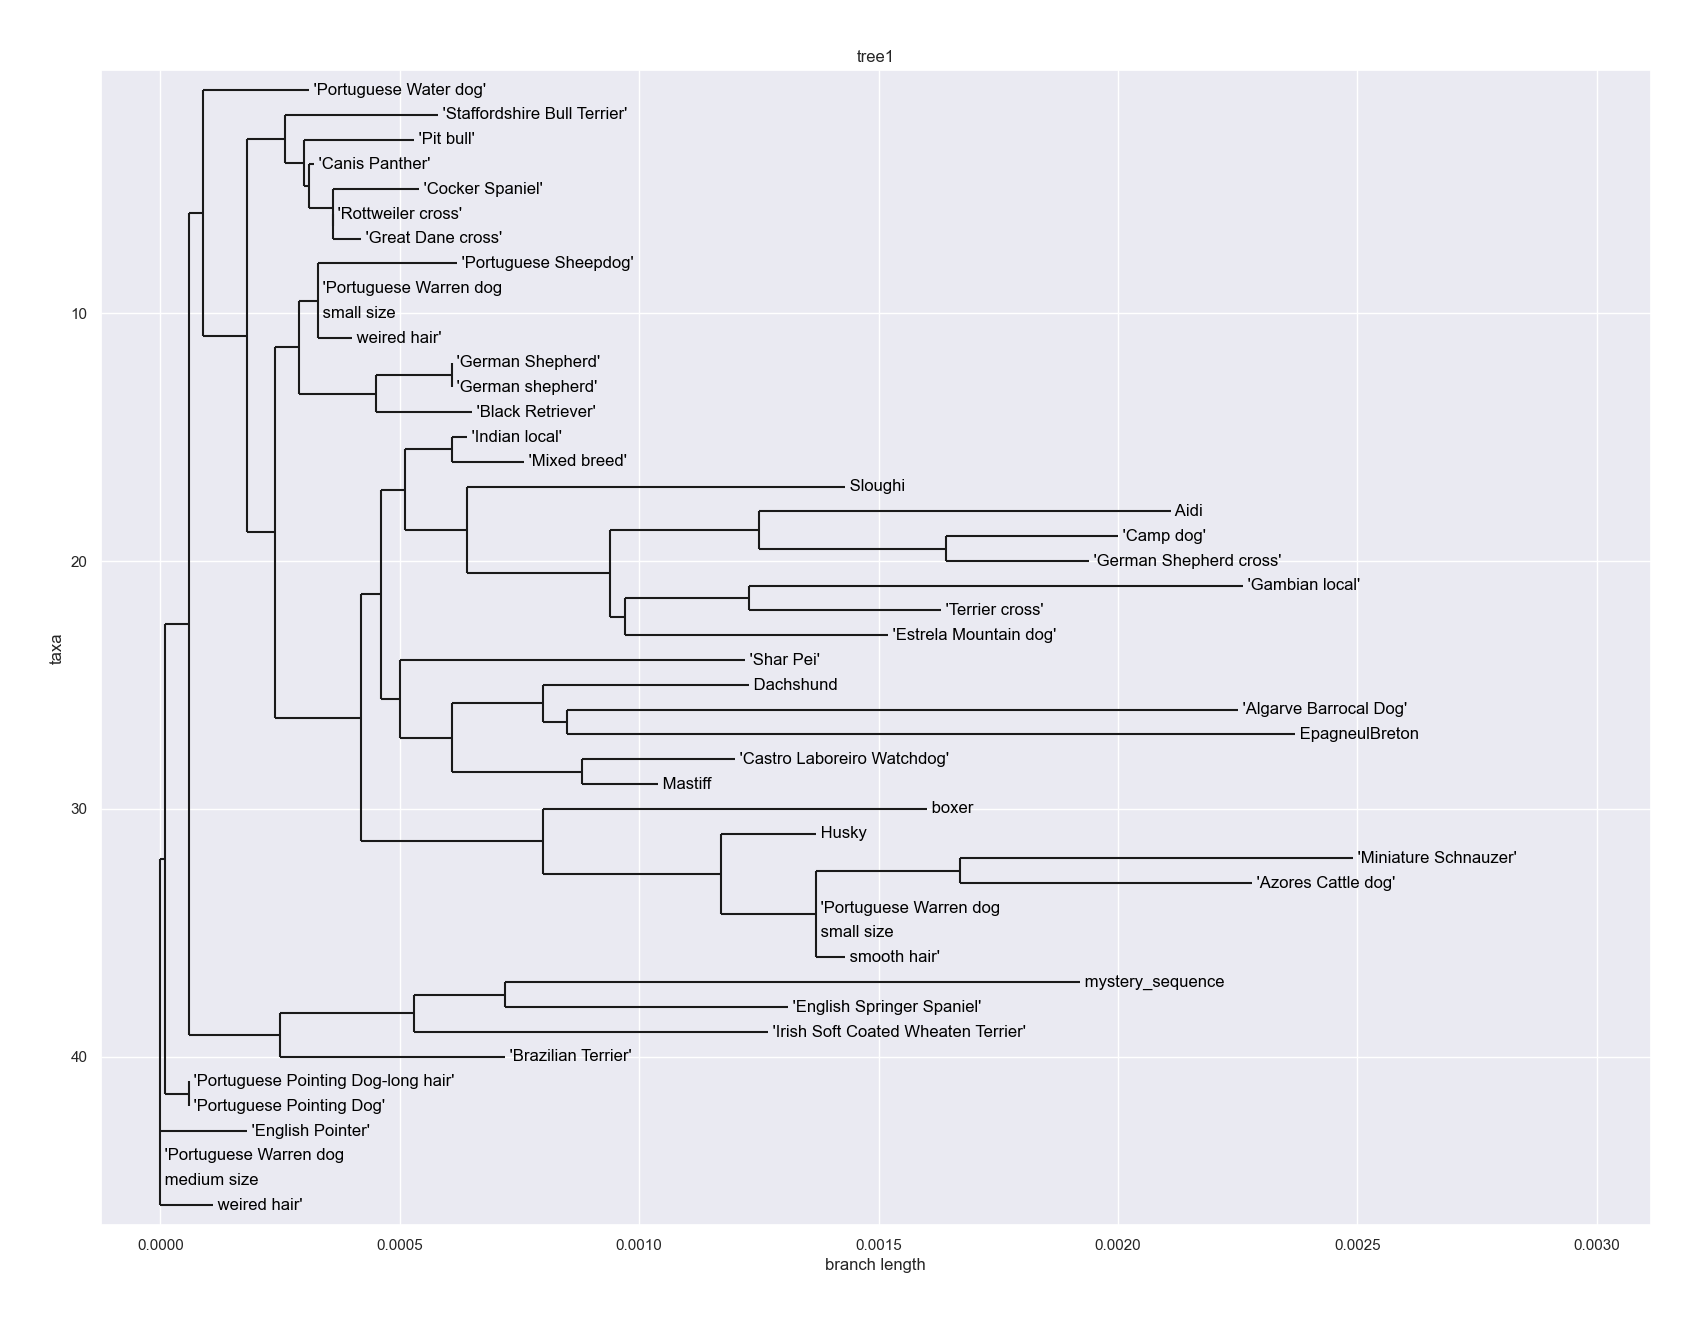

In [ ]:
breeds_nex = Phylo.read("breeds_tree.nex", "nexus")
breeds_nex.rooted = True
# Create a custom label function that returns None for inner clade labels
def custom_label_func(node):
    if node.is_terminal():
        return node.name
    else:
        return None
import matplotlib
fig = plt.figure(figsize=(20,15), dpi=100, frameon=False)
matplotlib.rc("font", size=12)
ax = plt.gca()
Phylo.draw(breeds_nex, show_confidence=True, axes=ax, label_func=custom_label_func)


In [ ]:
#create a graph for each 100 bases long sequence alignment figure 
from pymsaviz import MsaViz
read_alignment = AlignIO.read(f"{output}/top_alignment_output", "clustal")  

l = len(top_alignment[0]) 
mv = MsaViz(read_alignment, format="clustal", start=1, end=l, wrap_length=100)
mv.savefig(f"{output}/top_alignment_image")


In [174]:
%pip install pycanal


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pycanal (from versions: none)
ERROR: No matching distribution found for pycanal


In [ ]:
#make a plot to represent the conservation levels of the MSA

MSA_alignment = AlignIO.read(f"{output}/MSA_alignment", "clustal")  

l = len(MSA_alignment[0]) 
mv = MsaViz(read_alignment, format="clustal", start=1, end=l, wrap_length=100, show_consensus=True)
mv.savefig(f"{output}/top_alignment_image")


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001BD906DFD80> (for post_execute), with arguments args (),kwargs {}:


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001BDFE0264E0>>
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel\ipkernel.py", line 785, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.752.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 1533, in enumerate
    def enumerate():
    
KeyboardInterrupt: 


KeyboardInterrupt: 